In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
from scipy import stats

## Test thick file 

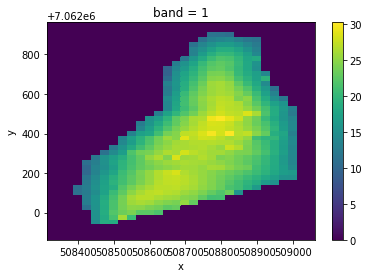

In [7]:
f = '/home/mowglie/disk/TMP_Data/GLOBAL_ITMIX/composite/RGI60-01/RGI60-01.00001_thickness.tif'
da = xr.open_rasterio(f)
da.plot();

In [8]:
da.sum() * da.attrs['res'][0]**2

<xarray.DataArray ()>
array(7638770.751953)

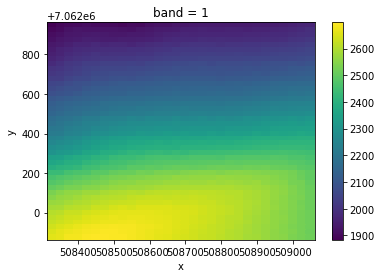

In [10]:
f = '/home/mowglie/disk/TMP_Data/GLOBAL_ITMIX/surface_DEMs_RGI60/surface_DEMs_RGI60-01/surface_DEM_RGI60-01.00001.tif'
de = xr.open_rasterio(f)
de.plot();

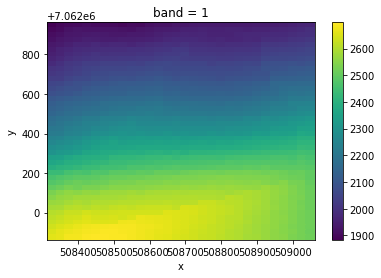

In [11]:
bed = de - da.data
bed.plot();

In [14]:
bed.where((da.data > 0) & (bed.data < 0)).sum() * da.attrs['res'][0]**2

<xarray.DataArray ()>
array(0.)

## OK, go

In [15]:
odf = pd.read_hdf('rgi62_era5_df.h5', 'df')

In [22]:
vol = np.full(len(odf), np.NaN)
vol_bsl = np.full(len(odf), np.NaN)
for i, (rid, reg) in enumerate(zip(odf.index, progressbar.progressbar(odf.O1Region))):
    fpath_c = '/home/mowglie/disk/TMP_Data/GLOBAL_ITMIX/composite/RGI60-{}/{}_thickness.tif'.format(reg, rid)
    fpath_d = '/home/mowglie/disk/TMP_Data/GLOBAL_ITMIX/surface_DEMs_RGI60/surface_DEMs_RGI60-{}/surface_DEM_{}.tif'.format(reg, rid)
    try:
        with xr.open_rasterio(fpath_c) as da:
            vol[i] = da.sum() * da.attrs['res'][0]**2
            with xr.open_rasterio(fpath_d) as de:
                bed = de - da.data
                vol_bsl[i] = bed.where((da.data > 0) & (bed.data < 0)).sum() * da.attrs['res'][0]**2
    except:
        pass

 99% (216489 of 216502) |############### | Elapsed Time: 0:20:01 ETA:   0:00:00

In [23]:
vol

array([7.63877075e+06, 1.69764600e+07, 5.96934619e+07, ...,
       2.50689258e+08, 1.06820602e+05, 1.48931555e+07])

In [24]:
vol_bsl

array([      0.        ,       0.        ,       0.        , ...,
       -359846.64916992,       0.        ,       0.        ])

In [25]:
print(np.sum(~np.isfinite(vol)))
vol[vol == 0] = np.NaN
print(np.sum(~np.isfinite(vol)))
odf['vol_itmix_m3'] = vol

973
982


In [27]:
print(np.sum(~np.isfinite(vol_bsl)))
vol_bsl[~np.isfinite(vol_bsl)] = 0
print(np.sum(~np.isfinite(vol_bsl)))
odf['vol_bsl_itmix_m3'] = np.abs(vol_bsl)

55402
0


In [28]:
odf['vol_bsl_itmix_m3'].sum() / odf['vol_itmix_m3'].sum()

0.15193551737212563

In [29]:
odf.to_hdf('rgi62_era5_itmix_nocorr_df.h5', key='df', mode='w')

/home/mowglie/.pyvirtualenvs/py3/lib/python3.5/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['GLIMSId', 'BgnDate', 'EndDate', 'O1Region', 'O2Region', 'Name', 'check_geom', 'GlacierType', 'TerminusType', 'GlacierStatus', 'unique_id']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Correct for no vol data 

In [31]:
dfs = odf[['Area', 'vol_itmix_m3']].copy().dropna()
dfs['vol_itmix_m3'] = dfs['vol_itmix_m3'] * 1e-9

In [32]:
# Fit in log space 
dfl = np.log(dfs).dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(dfl.Area.values, dfl.vol_itmix_m3.values)
print('linfit in log', slope, np.exp(intercept))

linfit in log 1.3241016673237342 0.03583913841744416


In [33]:
vol_vas = np.exp(intercept) * (odf['Area'] ** slope)

In [39]:
vol_vas.sum(), dfs['vol_itmix_m3'].sum(), dfs['vol_itmix_m3'].sum() - (odf['vol_bsl_itmix_m3'].sum() * 1e-9)

(163146.47164254752, 158156.59837634105, 134126.99377621617)

In [40]:
odf.loc[odf.vol_itmix_m3.isna(), 'vol_itmix_m3'] = vol_vas.loc[odf.vol_itmix_m3.isna()]

## Store 

In [47]:
odf.to_hdf('rgi62_era5_itmix_df.h5', key='df', mode='w')

/home/mowglie/.pyvirtualenvs/py3/lib/python3.5/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['GLIMSId', 'BgnDate', 'EndDate', 'O1Region', 'O2Region', 'Name', 'check_geom', 'GlacierType', 'TerminusType', 'GlacierStatus', 'unique_id']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [48]:
odf.to_csv('rgi62_era5_itmix_df.csv')

### Some checks 

In [41]:
dfs = odf[['Area', 'vol_itmix_m3']].copy().dropna()
dfs['vol_itmix_m3'] = dfs['vol_itmix_m3'] * 1e-9

In [42]:
vol_vas.sum(), dfs['vol_itmix_m3'].sum(), dfs['vol_itmix_m3'].sum() - (odf['vol_bsl_itmix_m3'].sum() * 1e-9)

(163146.47164254752, 158156.5983895423, 134126.99378941744)

In [43]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import ColorbarBase
from salem.graphics import ExtendedNorm
import copy

In [44]:
xvas = np.array([0.01, 1, 10, 100, 1000, 10000])
vas = 0.034*(xvas**1.375)
fit = np.exp(intercept) * (xvas ** slope)

In [45]:
xlim, ylim = [1e-2, 1e4], [1e-5, 1e4]
xlim_exp, ylim_exp = [-2, 4], [-5, 4]

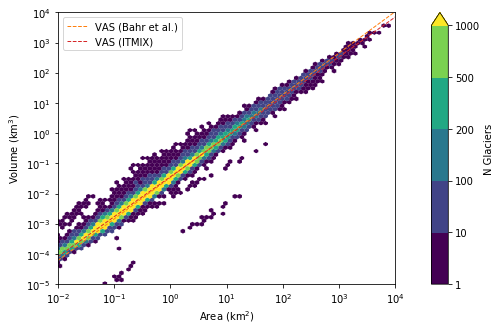

In [46]:
# Cmap norm
norm = ExtendedNorm([1, 10, 100, 200, 500, 1000], ncolors=256, extend='max')
cm = copy.deepcopy(plt.get_cmap('viridis'))
cm.set_under('white')

# Figure and plot
f, ax = plt.subplots(1, 1, figsize=(7, 5))

dfl.plot.hexbin(ax=ax, x="Area", y="vol_itmix_m3", norm=norm, cmap=cm, 
                colorbar=False, gridsize=70, linewidths=0.1);

# Fit
ax.plot(np.log(xvas), np.log(vas), '--', color='C1', label='VAS (Bahr et al.)', linewidth=1)
ax.plot(np.log(xvas), np.log(fit), '--', color='C3', label='VAS (ITMIX)', linewidth=1)

# Manipulate axes
ax.set_xlim(np.log(xlim))
ax.set_ylim(np.log(ylim))

xt = [10.**e for e in np.arange(xlim_exp[0], xlim_exp[1]+1)]
xl = ["10$^{"+"{:d}".format(int(x))+"}$" for x in np.arange(xlim_exp[0], xlim_exp[1]+1)]
ax.set_xticks(np.log(xt))
ax.set_xticklabels(xl)

yt = [10.**e for e in np.arange(ylim_exp[0], ylim_exp[1]+1)]
yl = ["10$^{"+"{:d}".format(int(x))+"}$" for x in np.arange(ylim_exp[0], ylim_exp[1]+1)]
ax.set_yticks(np.log(yt))
ax.set_yticklabels(yl)

# Legend
plt.legend();

ax.set_xlabel('Area (km$^{2}$)')
ax.set_ylabel('Volume (km$^{3}$)')

# Colorbar
cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.5)
ColorbarBase(cax, extend='max', orientation='vertical', cmap=cm, norm=norm, label='N Glaciers');